<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 01: OpenCompass 评估实践

> Author by: 许灿岷

## 1. 引言

### 1.1 大模型评估的重要性与挑战

随着 GPT-5、Claude、Llama 等大语言模型的快速发展，模型能力已经从简单的文本生成演进到复杂的推理、知识问答和多任务处理。如何科学、全面地评估这些模型的能力，成为学术界和工业界共同关注的核心问题。

**评估面临的三大挑战**：

1. **能力维度多样化**：现代大模型需要在知识掌握、逻辑推理、语言理解、数学计算等多个维度进行评估，单一指标难以全面反映模型性能。

2. **评估成本高昂**：完整评估一个模型需要在数十个数据集上运行数万条测试样本，消耗大量计算资源和时间成本。

3. **标准化困难**：不同研究机构使用的评估数据集、指标计算方法、提示工程技巧各不相同，导致评估结果难以横向对比。



### 1.2 OpenCompass 评测平台简介

**OpenCompass** 是由上海人工智能实验室开发的开源大模型评测体系，目前已成为国内最全面、使用最广泛的评估框架（GitHub Star 6.3k+）。

**核心特性**：

| 特性 | 说明 |
|------|------|
| **全面性** | 支持 70+ 评测数据集，覆盖 30万+ 测试题目 |
| **多维度** | 涵盖知识、推理、语言理解、数学等多个能力维度 |
| **标准化** | 统一的评估流程和指标计算，确保结果可复现 |
| **易扩展** | 支持自定义数据集、评估方法和可视化分析 |
| **自动化** | 一键启动评测流程，支持分布式并行加速 |

**支持的评估维度**：

- 📚 **知识掌握**：C-Eval（中文综合知识）、MMLU（英文多学科知识）
- 🧠 **推理能力**：BBH（复杂推理）、GSM8K（数学推理）
- 🌐 **语言理解**：C3（中文阅读理解）、CLUE（中文语言评估）
- 🛡️ **安全对齐**：Safety 评测集（内容安全性检测）



### 1.3 实验目标

**本文档目标**：

本实验将基于 OpenCompass 框架，以 **Qwen-3-4B** 为基准，引入 **Qwen2.5-0.5B** 和 **InternLM2.5-1.8B** 等端侧小模型进行横向对比评估。同时，还将探索 **LMDeploy** 推理加速引擎对评估效率的影响。通过可复现的实验流程，帮助初学者掌握：

1. ✅ OpenCompass 的完整安装和配置流程
2. ✅ 如何编写**多模型**评估配置文件并利用**多卡并行**启动任务
3. ✅ 评估结果的自动化解析、可视化对比（雷达图/柱状图）
4. ✅ **HuggingFace** 与 **LMDeploy (TurboMind)** 不同推理后端的配置与性能差异

**硬件环境说明**：

- **推荐配置**：双卡 GPU 环境（如 2x RTX 3080 Ti 或 4090），以体验并行评估的效率
- **数据集规模**：精简版（C-Eval + GSM8K + MMLU 部分子集）以快速验证流程



### 1.4 文档结构说明

本文档按照实验流程组织，章节结构如下：

- **第2章**：环境配置与模型下载（基础准备，含 ModelScope 极速下载）
- **第3章**：评估指标体系介绍（理论基础）
- **第4章**：数据集配置与准备（实验设计）
- **第5章**：多模型对比与可视化分析（核心实验：含多进程并行与 LMDeploy 加速）
- **第6章**：讨论与结论（总结 Scaling Law 及推理引擎差异）

---

## 2.模型评估前的准备

### 2.1 数据集准备

OpenCompass 支持两类数据集：
1. **HuggingFace 数据集**：运行时自动下载（需要网络）
2. **第三方数据集**：需要手动下载到 `data/` 目录

**下载数据集**：

In [ ]:
#在终端选择性执行以下命令

# 支持绝大多数数据集及模型
%pip install -U opencompass

# 完整安装（支持更多数据集）
# pip install "opencompass[full]"

# 模型推理后端，由于这些推理后端通常存在依赖冲突，建议使用不同的虚拟环境来管理它们。
# pip install "opencompass[lmdeploy]"
# pip install "opencompass[vllm]"

# API 测试（例如 OpenAI、Qwen）
# pip install "opencompass[api]"

# 安装 LMDeploy 加速推理
%pip install lmdeploy

In [6]:
#OpenCompass支持使用本地数据集进行评测，数据集的下载和解压可以通过以下命令完成:

#下载数据集到 data/ 处
!wget https://github.com/open-compass/opencompass/releases/download/0.2.2.rc1/OpenCompassData-core-20240207.zip
!unzip OpenCompassData-core-20240207.zip

--2025-12-04 22:25:25--  https://github.com/open-compass/opencompass/releases/download/0.2.2.rc1/OpenCompassData-core-20240207.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/654124617/b6ea57a4-4c8c-4be6-afa3-c63a5e511564?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-04T15%3A01%3A43Z&rscd=attachment%3B+filename%3DOpenCompassData-core-20240207.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-04T14%3A00%3A55Z&ske=2025-12-04T15%3A01%3A43Z&sks=b&skv=2018-11-09&sig=yGHqwFhGp1%2Fnw%2FF%2BwtH93b57BpWto4kbbNPmz7xv5yk%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDg2MTkyNiwibmJmIjoxNzY0

**检查数据集**：

In [75]:

# 查看可用数据集列表
import os
from pathlib import Path

# 假设当前在 opencompass 目录
opencompass_root = Path("./")  # 根据实际路径调整

if opencompass_root.exists():
    data_dir = opencompass_root / "data"
    if data_dir.exists():
        datasets = [d.name for d in data_dir.iterdir() if d.is_dir()]
        print(f"✅ 已准备 {len(datasets)} 个数据集:")
        for ds in sorted(datasets)[:10]:  # 只显示前10个
            print(f"  - {ds}")
        if len(datasets) > 10:
            print(f"  ... 还有 {len(datasets)-10} 个数据集")
    else:
        print("❌ data 目录不存在，请先下载数据集")
else:
    print("ℹ️ 请在 opencompass 项目根目录执行数据集下载命令")

✅ 已准备 33 个数据集:
  - AGIEval
  - ARC
  - BBH
  - CLUE
  - FewCLUE
  - GAOKAO-BENCH
  - LCSTS
  - SuperGLUE
  - TheoremQA
  - Xsum
  ... 还有 23 个数据集


### 2.2 模型配置与加载

本实验使用 **Qwen-3-4B-Instruct** 作为评估对象。该模型参数量为 40 亿，支持中英双语，适合在 8-12GB 显存的 GPU 上运行。

**模型下载方式**：

1. **自动下载**（推荐）：首次运行时从 HuggingFace 自动下载
2. **手动下载**：如果网络受限，可从 ModelScope 镜像下载


In [ ]:
# 先安装（如未安装）
%pip install -U huggingface_hub transformers

# 下载模型（走国内镜像）
from huggingface_hub import snapshot_download

print("📥 开始下载 Qwen3-4B-Instruct-2507...")
snapshot_download(
    repo_id="Qwen/Qwen3-4B-Instruct-2507",
    local_dir="./models/Qwen3-4B-Instruct-2507",
    local_dir_use_symlinks=False,
    endpoint="https://hf-mirror.com",
    max_workers=8  # 加速下载
)
print("✅ 下载完成！")


**重要参数说明**：

| 参数 | 说明 | 推荐值 |
|------|------|--------|
| `trust_remote_code` | 允许执行模型自定义代码（Qwen系列必需） | `True` |
| `device_map` | 自动分配GPU/CPU | `"auto"` |
| `max_seq_len` | 最大输入序列长度 | `2048` |
| `batch_size` | 批处理大小（影响显存占用） | `8`（8GB显存）<br/>`16`（12GB+显存） |

下面演示如何加载模型（实际评估时 OpenCompass 会自动处理）：

In [78]:
# 注意：此代码仅用于演示模型加载，实际评估时 OpenCompass 会自动处理
# 如果显存不足或网络失败，可以跳过此单元格，并参考下方的“手动下载”说明
try:
    import logging
    logging.basicConfig(level=logging.INFO)

    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch

    model_path = "./models/Qwen3-4B-Instruct-2507"

    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        dtype=torch.float16,
        trust_remote_code=True
    )

    print(f"✅ 模型加载成功!")
    print(f"   模型参数量: {model.num_parameters() / 1e9:.2f}B")
    print(f"   模型设备: {model.device}")

    # 简单推理测试
    test_input = "请用一句话介绍opencompass评估模型的优势："
    inputs = tokenizer(test_input, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=50)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"\n📝 推理测试结果:")
    print(f"   输入: {test_input}")
    print(f"   输出: {response[len(test_input):].strip()}")

    # 清理显存
    del model, tokenizer
    torch.cuda.empty_cache()
    print("\n💾 显存已释放")

except Exception as e:
    print(f"⚠️ 自动下载或加载失败: {type(e).__name__}: {e}")

INFO:accelerate.utils.modeling:We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 模型加载成功!
   模型参数量: 4.02B
   模型设备: cuda:0

📝 推理测试结果:
   输入: 请用一句话介绍opencompass评估模型的优势：
   输出: OpenCompass通过统一的评估框架和多维度的评测指标，实现了对大语言模型在不同任务和场景下的全面、公平、可解释的性能评估。 优化这句话，使其更简洁、清晰、有说服力

💾 显存已释放


`trust_remote_code=True` 参数允许加载模型自定义的神经网络结构，这是 Qwen 系列模型的特殊要求。`device_map="auto"` 启用自动设备映射，优化多 GPU 环境下的内存使用效率。


## 3. 评估指标体系构建

大模型评估需要多维度指标体系，涵盖基础能力、任务性能、生成质量和系统工程四个层面。

**基础能力指标**：

- Perplexity：衡量语言模型预测能力，计算公式为：
  $PPL(X) = \exp\left(-\frac{1}{N}\sum_{i=1}^{N}\log P(x_i|x_1, x_2, ..., x_{i-1})\right)$
- BLEU、ROUGE：评估文本生成质量

**任务性能指标**：

- 准确率/F1 值：用于分类任务评估
- Recall@k、MRR：用于检索任务评估

**生成质量指标**：

- 流畅度：语法正确性和文本连贯性
- 事实性：FactScore 知识准确性指标
- 安全性：毒性检测和偏见分析



## 4. 数据集选择与评估配置

OpenCompass 支持多种评估数据集，针对不同能力维度选择相应数据集：

### 4.1 数据集概览

OpenCompass 支持 100+ 评估数据集，涵盖多个能力维度。针对不同能力维度，我们选择以下代表性数据集：

| 能力维度 | 数据集 | 说明 | 题目数量 |
|----------|--------|------|----------|
| 中文知识 | **C-Eval** | 中文综合能力评估，涵盖52个学科 | 本实验选取200题 |
| 数学推理 | **GSM8K** | 小学数学应用题推理能力 | 本实验选取100题 |
| 英文知识 | MMLU（可选） | 多学科英文知识问答 | 可选100题 |

**为什么不包含代码生成评测（HumanEval）？**

代码生成评测需要执行模型生成的代码，存在安全风险，不适合初学者教学环境。我们聚焦于安全的知识问答和推理任务。


### 4.2 命令行快速评估

OpenCompass 提供了更简单的命令行方式，无需编写配置文件：

命令行界面 (CLI) 可执行以下命令
```bash
opencompass --models hf_internlm2_5_1_8b_chat --datasets demo_gsm8k_chat_gen
```

### 4.3 Pyhton脚本快速评估
而对于更复杂的评估，则建议使用脚本方式。你可以在[examples](https://github.com/open-compass/opencompass/blob/main/examples)文件夹下找到更多脚本示例。

#### 4.3.1 配置文件编写

OpenCompass 可以使用 Python 配置文件来定义评估任务。配置文件包含两个核心部分：
1. **datasets**：要评估的数据集列表
2. **models**：要评估的模型列表

执行下面的代码单元块以生成临时评估脚本 configs/eval_qwen_demo.py

In [1]:
import os

# 确保 configs 目录存在
os.makedirs('configs', exist_ok=True)

# 定义配置文件路径
config_path = 'configs/eval_qwen_demo.py'

In [ ]:
%%writefile configs/eval_qwen_demo_lmddeploy.py
# ====================================
# OpenCompass 评估配置文件 (LMDeploy 加速版)
# 用途: 使用 TurboMind 引擎极速评估 Qwen-3-4B
# ====================================

from mmengine.config import read_base
# 引入 LMDeploy 包装类 (它是调用 TurboMind 的标准入口)
from opencompass.models import TurboMindModelwithChatTemplate

# ============ 第1部分: 导入数据集配置 ============
with read_base():
    from opencompass.configs.datasets.ceval.ceval_gen_5f30c7 import ceval_datasets
    from opencompass.configs.datasets.gsm8k.gsm8k_gen_1d7fe4 import gsm8k_datasets
    from opencompass.configs.datasets.mmlu.mmlu_gen_a484b3 import mmlu_datasets

# 组合数据集列表 (精简版)
datasets = [
    *ceval_datasets[:1],
    *gsm8k_datasets[:1],
    *mmlu_datasets[:1],
]

# ============ 第2部分: 配置待评估模型 ============
models = [
    dict(
        # 【关键】使用 TurboMindModelwithChatTemplate
        type=TurboMindModelwithChatTemplate,
        abbr='qwen-3-4b-turbomind',

        # 指向本地模型路径
        path='./models/Qwen3-4B-Instruct-2507',

        # --- 引擎参数 (TurboMind Engine Config) ---
        engine_config=dict(
            # 上下文窗口大小
            session_len=4096,
            # 最大批处理大小 (LMDeploy 非常高效，128 没问题)
            max_batch_size=128,
            # Tensor Parallel (TP): 单卡运行设为 1
            tp=1,
            # 显存缓存比例 (0.0-1.0)，如果不设置会自动占满显存
            # 设为 0.4 可以给其他进程留点空间，设为 None 则自动管理
            cache_max_entry_count=0.5,
            # 强制使用 bf16
            model_format='hf',
        ),

        # --- 生成参数 (Generation Config) ---
        gen_config=dict(
            top_k=1,
            temperature=1e-6,
            top_p=0.9,
        ),

        # OpenCompass 侧的批处理设置
        batch_size=128,
        max_out_len=512,
        max_seq_len=2048,

        # 运行配置: 单个模型实例占用 1 张卡
        run_cfg=dict(num_gpus=1, num_procs=1),
    )
]

# ============ 第3部分: 工作目录配置 ============
work_dir = './outputs/qwen_demo_lmdeploy'

Overwriting configs/eval_qwen_demo.py


#### 4.3.2 执行评估脚本
在Jupyter环境内需要 run.py 脚本：

In [10]:
%%writefile run.py
from opencompass.cli.main import main

if __name__ == '__main__':
    main()

Overwriting run.py


执行下面的代码单元块以执行评估脚本configs/eval_qwen_demo_lmddeploy.py

评估脚本启动评估的时间比较长，请保持耐心！！

In [ ]:
# 定义运行命令
# 使用 --debug 模式可以实时看到输出
# 如果想后台运行并只看结果，去掉 --debug

#终端环境内: 执行以下命令
#opencompass configs/eval_qwen_demo_lmddeploy.py --debug
#或者
#python run.py configs/eval_qwen_demo_lmddeploy.py --debug

#Jupyter环境内: sys.executable 为当前 Conda 环境的 Python 绝对路径
import sys
import os

# 获取当前 Conda 环境的 Python 绝对路径
python_path = sys.executable
print(f"🔧 使用 Python 解释器: {python_path}")

!{sys.executable} run.py configs/eval_qwen_demo_lmddeploy.py --max-num-workers 2 --debug

🔧 使用 Python 解释器: /root/miniconda3/envs/opencompass/bin/python
/root/miniconda3/envs/opencompass/lib/python3.10/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
12/06 22:56:13 - OpenCompass - INFO - Current exp folder: ./outputs/qwen_demo_lmdeploy/20251206_225613
12/06 22:56:14 - OpenCompass - WARNING - SlurmRunner is not used, so the partition argument is ignored.
12/06 22:56:14 - OpenCompass - INFO - Partitioned into 2 tasks.
12/06 22:56:17 - OpenCompass - WARNING - Only use 1 GPUs for total 2 available GPUs in debug mode.
12/06 22:56:17 - OpenCompass - INFO - Task [qwen-3-4b-turbomind/ceval-computer_network_0,qwen-3-4b-turbomind/gsm8k_0,qwen-3-4b-turbomind/lukaemon_mmlu_college_biology_0]
`torch_dtype` is deprecated! Use `dtype` instead!

#### 4.3.3 可视化评估结果


📂 Loading Report: summary_20251206_225613.csv

📊 Overall Performance (Average):
(Calculated Average)


,qwen-3-4b-turbomind
Calculated Average,85.743333



📋 Detailed Scores:


,dataset,qwen-3-4b-turbomind
0,ceval-computer_network,78.95
1,gsm8k,89.39
2,lukaemon_mmlu_college_biology,88.89



📈 1. Radar Chart


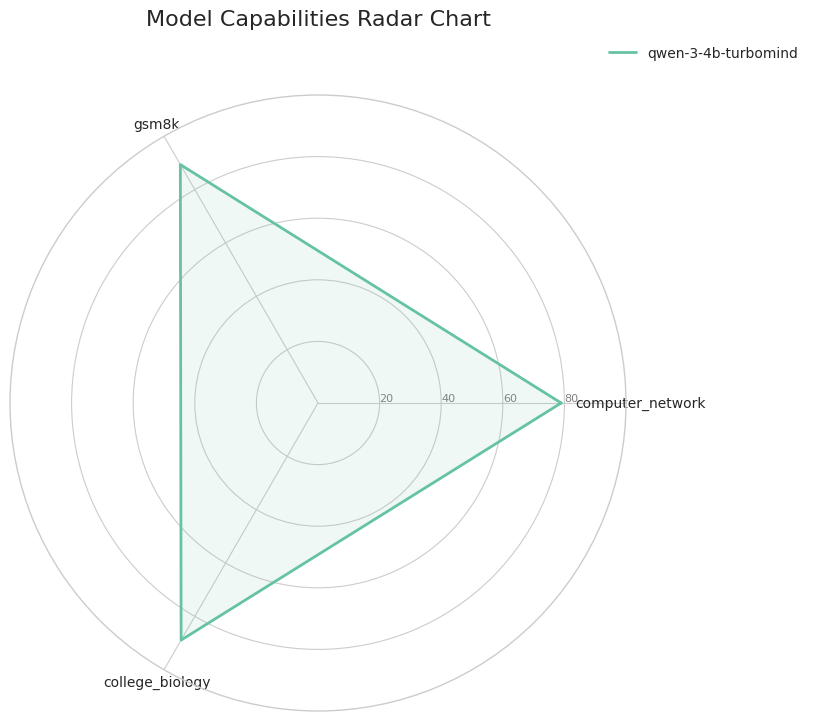


📊 2. Bar Chart


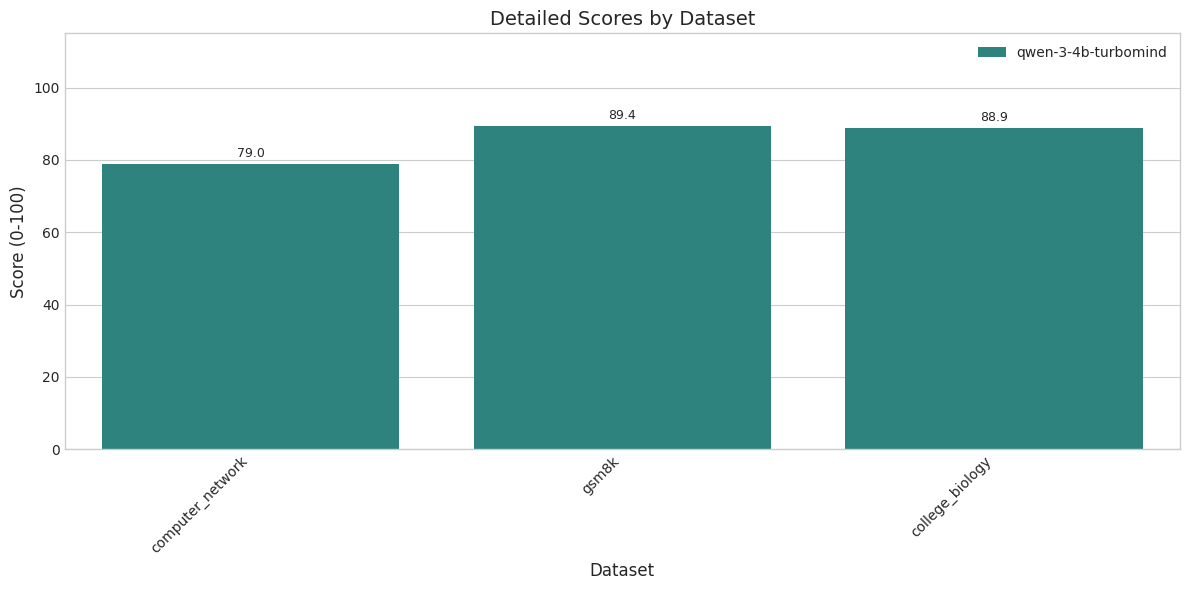

In [13]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# ================= Configuration =================
# Path to OpenCompass outputs
OUTPUT_ROOT = './outputs'
# ===============================================

# Set style (Use default sans-serif to avoid font issues)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']

def find_latest_summary_csv(root_dir):
    """Automatically find the latest summary CSV file."""
    search_pattern = os.path.join(root_dir, '*', '*', 'summary', '*.csv')
    csv_files = glob.glob(search_pattern)
    if not csv_files: return None
    return max(csv_files, key=os.path.getmtime)

def clean_dataset_name(name):
    """Clean up dataset names for better visualization."""
    if not isinstance(name, str): return str(name)
    # Remove common prefixes like 'ceval-', 'lukaemon_mmlu_'
    name = name.replace('ceval-', '').replace('lukaemon_mmlu_', '')
    # If it still contains hyphens, take the last part
    if '-' in name: name = name.split('-')[-1]
    return name

def plot_radar_chart(df, model_cols, dataset_col='short_name'):
    """Plot Radar Chart for model capabilities."""
    categories = df[dataset_col].tolist()
    N = len(categories)

    # Calculate angles
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Setup axis
    plt.xticks(angles[:-1], categories, size=10)
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80], ["20", "40", "60", "80"], color="grey", size=8)
    plt.ylim(0, 100)

    # Color palette
    colors = sns.color_palette("Set2", len(model_cols))

    # Plot each model
    for idx, model in enumerate(model_cols):
        values = df[model].tolist()
        values += values[:1] # Close the loop
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[idx])
        ax.fill(angles, values, color=colors[idx], alpha=0.1)

    plt.title("Model Capabilities Radar Chart", size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

def plot_bar_chart(df, model_cols, dataset_col='short_name'):
    """Plot Bar Chart for detailed scores."""
    # Convert to Long Format for Seaborn
    df_melted = df.melt(id_vars=[dataset_col], value_vars=model_cols,
                        var_name='Model', value_name='Score')

    plt.figure(figsize=(12, 6))
    chart = sns.barplot(x=dataset_col, y='Score', hue='Model', data=df_melted, palette='viridis')

    # Add value labels
    for container in chart.containers:
        chart.bar_label(container, fmt='%.1f', padding=3, size=9)

    plt.title("Detailed Scores by Dataset", size=14)
    plt.xlabel("Dataset", size=12)
    plt.ylabel("Score (0-100)", size=12)
    plt.ylim(0, 115) # Space for labels
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def analyze_results():
    # 1. Find File
    csv_path = find_latest_summary_csv(OUTPUT_ROOT)
    if not csv_path:
        print(f"❌ No summary CSV found in {OUTPUT_ROOT}")
        print("Please check if the evaluation process finished successfully.")
        return

    print(f"📂 Loading Report: {os.path.basename(csv_path)}")
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return

    # 2. Data Cleaning
    # Identify model columns (exclude metadata)
    metadata_cols = ['dataset', 'version', 'metric', 'mode']
    model_cols = [c for c in df.columns if c not in metadata_cols]

    if not model_cols:
        print("⚠️ No model columns found in CSV.")
        display(df.head())
        return

    # Create short names
    df['short_name'] = df['dataset'].apply(clean_dataset_name)

    # Separate Average row
    avg_row = df[df['dataset'] == 'Average']
    plot_df = df[df['dataset'] != 'Average'].copy()

    # 3. Display Data
    print("\n📊 Overall Performance (Average):")
    if not avg_row.empty:
        display(avg_row[['dataset'] + model_cols])
    else:
        # Calculate average manually if missing
        print("(Calculated Average)")
        avg_scores = plot_df[model_cols].mean()
        avg_df = pd.DataFrame(avg_scores).T
        avg_df.index = ['Calculated Average']
        display(avg_df)

    print("\n📋 Detailed Scores:")
    display(plot_df[['dataset'] + model_cols].head())

    # 4. Visualization
    if not plot_df.empty:
        # Ensure numeric
        for col in model_cols:
            plot_df[col] = pd.to_numeric(plot_df[col], errors='coerce').fillna(0)

        print("\n📈 1. Radar Chart")
        plot_radar_chart(plot_df, model_cols)

        print("\n📊 2. Bar Chart")
        plot_bar_chart(plot_df, model_cols)
    else:
        print("⚠️ No dataset data available for plotting.")

# Run Analysis
analyze_results()

## 5. 多模型对比与可视化分析

### 5.1 多模型评估配置

除了本地模型评估，OpenCompass 还支持通过 API 评估商业大模型（如 GPT-3.5、GLM-4 等），便于横向对比，可以取消下面注释来使用。

**下载其他模型**

In [ ]:
import os
from huggingface_hub import snapshot_download

# 定义要下载的模型列表
models_list = [
    {
        "repo_id": "Qwen/Qwen2.5-0.5B-Instruct",
        "local_dir": "./models/Qwen2.5-0.5B-Instruct"
    },
    {
        "repo_id": "internlm/internlm2_5-1_8b-chat",
        "local_dir": "./models/internlm2_5-1_8b-chat"
    }
]

print("🚀 开始批量下载模型...\n" + "="*50)

for model_info in models_list:
    repo_id = model_info["repo_id"]
    local_dir = model_info["local_dir"]

    print(f"📥 正在下载: {repo_id}")
    try:
        snapshot_download(
            repo_id=repo_id,
            local_dir=local_dir,
            local_dir_use_symlinks=False,  # 不使用软链接，方便管理
            endpoint="https://hf-mirror.com", # 使用国内镜像
            max_workers=8
        )
        print(f"✅ 下载完成，存储于: {local_dir}\n")
    except Exception as e:
        print(f"❌ 下载失败 {repo_id}: {e}\n")

print("="*50 + "\n🎉 所有模型下载流程结束！")

🚀 开始批量下载模型...
📥 正在下载: Qwen/Qwen2.5-0.5B-Instruct


/root/miniconda3/envs/opencompass/lib/python3.10/site-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

generation_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

✅ 下载完成，存储于: ./models/Qwen2.5-0.5B-Instruct

📥 正在下载: internlm/internlm2_5-1_8b-chat


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

configuration_internlm2.py: 0.00B [00:00, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

tokenization_internlm2_fast.py: 0.00B [00:00, ?B/s]

modeling_internlm2.py: 0.00B [00:00, ?B/s]

tokenization_internlm2.py: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

✅ 下载完成，存储于: ./models/internlm2_5-1_8b-chat

🎉 所有模型下载流程结束！


**配置多模型评估**

In [ ]:
%%writefile configs/eval_small_models_lmdeploy.py
from mmengine.config import read_base
from opencompass.models import TurboMindModelwithChatTemplate

with read_base():
    from opencompass.configs.datasets.ceval.ceval_gen_5f30c7 import ceval_datasets
    from opencompass.configs.datasets.gsm8k.gsm8k_gen_1d7fe4 import gsm8k_datasets
    from opencompass.configs.datasets.mmlu.mmlu_gen_a484b3 import mmlu_datasets

# 数据集保持不变
datasets = [*ceval_datasets[:1], *gsm8k_datasets[:1], *mmlu_datasets[:1]]

models = [
    # --- Qwen2.5-0.5B (LMDeploy版) ---
    dict(
        type=TurboMindModelwithChatTemplate,
        abbr='qwen2.5-0.5b-instruct',
        path='./models/Qwen2.5-0.5B-Instruct',

        # LMDeploy 特有参数
        engine_config=dict(
            session_len=2048,  # 上下文长度
            max_batch_size=128,# 最大批处理
            tp=1,              # Tensor Parallel (单卡设为1)
        ),
        gen_config=dict(
            top_k=1, temperature=1e-6, top_p=0.9  # 生成参数
        ),

        max_out_len=512,
        max_seq_len=2048,
        batch_size=128,    # 这里的 Batch Size 真正能跑满
        run_cfg=dict(num_gpus=1, num_procs=1),
    ),

    # --- InternLM2.5-1.8B (LMDeploy版) ---
    dict(
        type=TurboMindModelwithChatTemplate,
        abbr='internlm2.5-1.8b-chat',
        path='./models/internlm2_5-1_8b-chat',

        engine_config=dict(
            session_len=2048,
            max_batch_size=64,
            tp=1,
        ),
        gen_config=dict(
            top_k=1, temperature=1e-6, top_p=0.9
        ),

        max_out_len=512,
        max_seq_len=2048,
        batch_size=64,
        run_cfg=dict(num_gpus=1, num_procs=1),
    )
]

work_dir = './outputs/small_models_demo_lmdeploy'

Overwriting configs/eval_small_models_lmdeploy.py


In [ ]:
import sys
# 启动多模型评估 (双卡并行)
!{sys.executable} run.py configs/eval_small_models_lmdeploy.py --max-num-workers 2

#单卡
# !{sys.executable} run.py configs/eval_small_models_lmdeploys.py

/root/miniconda3/envs/opencompass/lib/python3.10/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
12/06 22:43:41 - OpenCompass - INFO - Current exp folder: ./outputs/small_models_demo_lmdeploy/20251206_224341
12/06 22:43:41 - OpenCompass - WARNING - SlurmRunner is not used, so the partition argument is ignored.
12/06 22:43:41 - OpenCompass - INFO - Partitioned into 4 tasks.
launch OpenICLInfer[qwen2.5-0.5b-instruct/ceval-computer_network_0,qwen2.5-0.5b-instruct/gsm8k_0,qwen2.5-0.5b-instruct/lukaemon_mmlu_college_biology_0] on GPU 0
launch OpenICLInfer[qwen2.5-0.5b-instruct/ceval-computer_network_1,qwen2.5-0.5b-instruct/gsm8k_1,qwen2.5-0.5b-instruct/lukaemon_mmlu_college_biology_1] on GPU 1
launch OpenICLInfer[internlm2.5-1.8b-chat/ceval-co

### 5.2 多模型性能对比可视化

使用 Matplotlib 和 Seaborn 生成学术论文级别的性能对比图表。以下代码支持从真实评估结果读取数据：


🔄 开始合并并可视化...
🔍 正在扫描 5 个任务目录...
   📖 读取: 20251206_003454/summary_20251206_003454.csv
   ⚪ 跳过 (无结果): .ipynb_checkpoints
   📖 读取: 20251206_224341/summary_20251206_224341.csv
   ⚪ 跳过 (无结果): small_models_demo
   📖 读取: 20251206_225613/summary_20251206_225613.csv

✅ 成功合并数据! 发现模型: ['qwen-3-4b-instruct', 'qwen2.5-0.5b-instruct', 'internlm2.5-1.8b-chat', 'qwen-3-4b-turbomind']


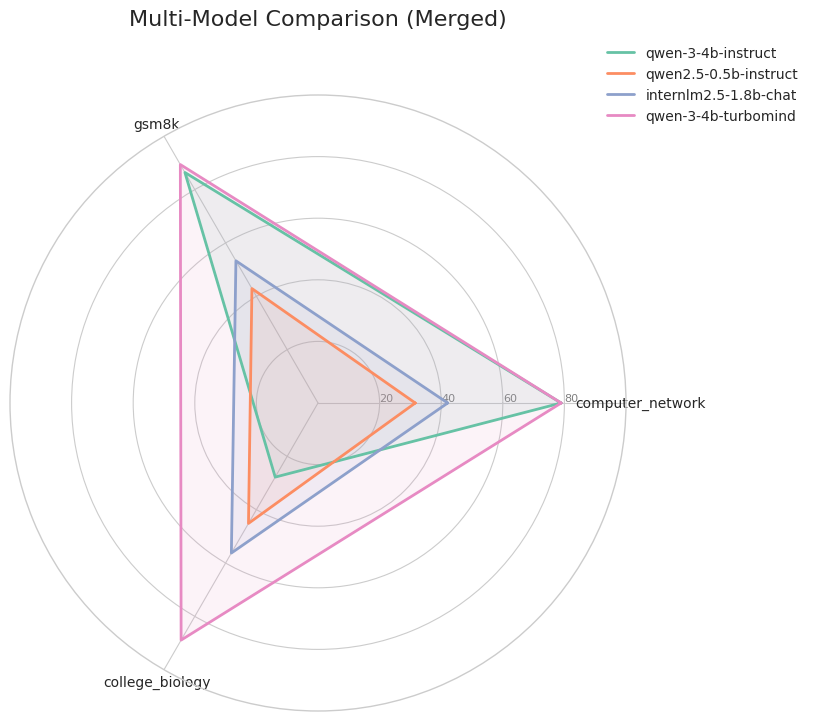

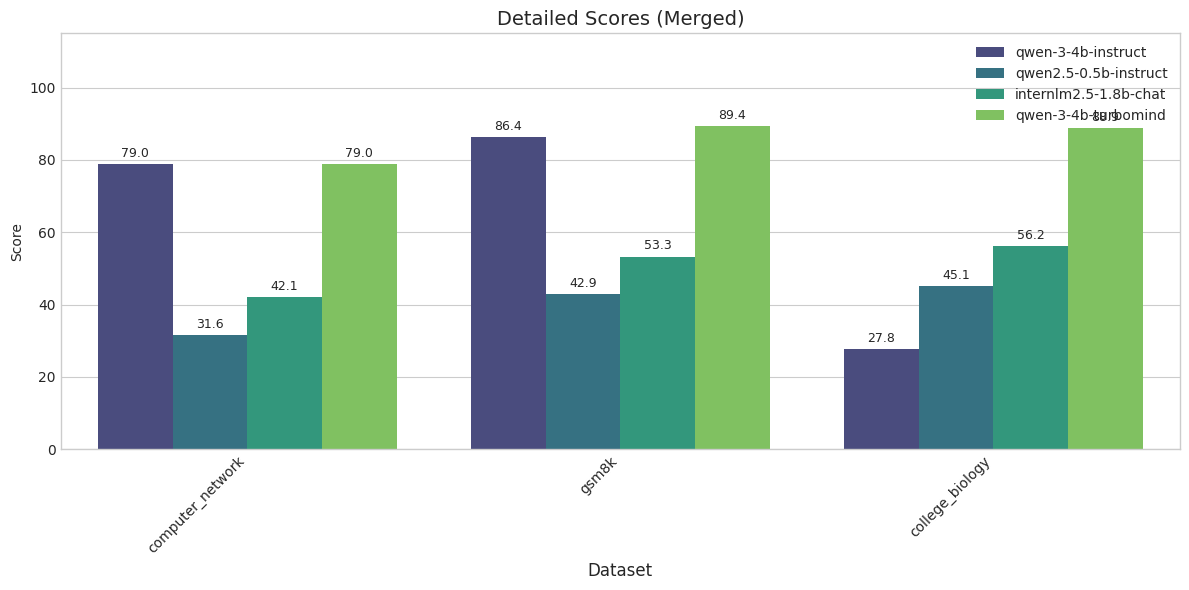

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

# ================= 配置区域 =================
OUTPUT_ROOT = './outputs'
# ===========================================

# 样式设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']

def get_latest_csv_from_dir(task_dir):
    """在指定的任务目录中找到最新的 summary CSV"""
    # 路径模式: task_dir/时间戳/summary/*.csv
    pattern = os.path.join(task_dir, '*', 'summary', '*.csv')
    files = glob.glob(pattern)
    if not files: return None
    return max(files, key=os.path.getmtime)

def merge_evaluation_results(root_dir):
    """扫描根目录下所有子任务，并合并结果"""
    merged_df = pd.DataFrame()

    # 1. 遍历 outputs 下的所有子目录 (qwen_demo, small_models_demo ...)
    if not os.path.exists(root_dir):
        print(f"❌ 目录不存在: {root_dir}")
        return None

    task_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    print(f"🔍 正在扫描 {len(task_dirs)} 个任务目录...")

    for task_dir in task_dirs:
        csv_file = get_latest_csv_from_dir(task_dir)
        if csv_file:
            print(f"   📖 读取: {os.path.basename(os.path.dirname(os.path.dirname(csv_file)))}/{os.path.basename(csv_file)}")
            try:
                # 读取 CSV
                df = pd.read_csv(csv_file)
                # 过滤 Average 行
                df = df[df['dataset'] != 'Average']

                # 如果是第一次读取，直接赋值
                if merged_df.empty:
                    merged_df = df
                else:
                    # 合并逻辑：基于 dataset, version, metric, mode 进行合并
                    # 这样可以把不同 CSV 里的模型列拼接到一起
                    merge_cols = ['dataset', 'version', 'metric', 'mode']
                    # 仅保留 merge_cols 和模型列
                    df = df[merge_cols + [c for c in df.columns if c not in merge_cols]]
                    merged_df = pd.merge(merged_df, df, on=merge_cols, how='outer')
            except Exception as e:
                print(f"   ⚠️ 读取失败: {e}")
        else:
            print(f"   ⚪ 跳过 (无结果): {os.path.basename(task_dir)}")

    return merged_df

def clean_name(name):
    if not isinstance(name, str): return str(name)
    return name.replace('ceval-', '').replace('lukaemon_mmlu_', '').split('-')[-1]

def plot_radar(df, model_cols):
    categories = df['short_name'].tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, size=10)
    ax.set_rlabel_position(0)
    plt.yticks([20, 40, 60, 80], ["20", "40", "60", "80"], color="grey", size=8)
    plt.ylim(0, 100)

    colors = sns.color_palette("Set2", len(model_cols))
    for idx, model in enumerate(model_cols):
        # 处理可能的 NaN (比如某个模型没跑某个数据集)
        values = df[model].fillna(0).tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=model, color=colors[idx])
        ax.fill(angles, values, color=colors[idx], alpha=0.1)

    plt.title("Multi-Model Comparison (Merged)", size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

def plot_bar(df, model_cols):
    df_melted = df.melt(id_vars=['short_name'], value_vars=model_cols,
                        var_name='Model', value_name='Score')

    plt.figure(figsize=(12, 6))
    chart = sns.barplot(x='short_name', y='Score', hue='Model', data=df_melted, palette='viridis')
    for container in chart.containers:
        chart.bar_label(container, fmt='%.1f', padding=3, size=9)

    plt.title("Detailed Scores (Merged)", size=14)
    plt.xlabel("Dataset", size=12)
    plt.ylim(0, 115)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# === 主程序 ===
print("\n🔄 开始合并并可视化...")
final_df = merge_evaluation_results(OUTPUT_ROOT)

if final_df is not None and not final_df.empty:
    # 识别模型列
    meta_cols = ['dataset', 'version', 'metric', 'mode']
    model_cols = [c for c in final_df.columns if c not in meta_cols]

    print(f"\n✅ 成功合并数据! 发现模型: {model_cols}")

    # 预处理
    final_df['short_name'] = final_df['dataset'].apply(clean_name)
    # 转换数值
    for col in model_cols:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

    # 绘图
    plot_radar(final_df, model_cols)
    plot_bar(final_df, model_cols)
else:
    print("❌ 未能合并到有效数据，请检查 outputs 目录结构。")

最终清理临时文件：

In [ ]:
import os
import shutil

# =======================================================
# 🧹 实验环境清理配置 (请根据需要修改 True/False)
# =======================================================

# 1. 清理 评估结果与日志 (outputs 目录)
#    说明: 删除生成的表格、日志、预测结果。下次运行会重新生成。
CLEAN_OUTPUTS = True

# 2. 清理 临时配置与脚本 (configs 目录, run.py)
#    说明: 删除生成的配置文件和启动脚本。
CLEAN_SCRIPTS = True

# 3. 清理 数据集 (data 目录)
#    说明: 删除 C-Eval/GSM8K 等数据集。下次运行需重新解压/下载。
CLEAN_DATA = False

# 4. [⚠️慎选] 清理 模型文件 (models 目录)
#    说明: 包含 Qwen, InternLM 等权重文件 (GB级别)。
#    警告: 删除后下次必须重新下载，耗时较长！仅在磁盘空间不足时开启。
CLEAN_MODELS = False

# =======================================================

def safe_remove(path, description):
    """安全删除文件或目录的辅助函数"""
    if not os.path.exists(path):
        print(f"⚪ [跳过] 不存在: {path}")
        return

    try:
        if os.path.isfile(path) or os.path.islink(path):
            os.remove(path)
            print(f"✅ [已删除] 文件: {description} ({path})")
        elif os.path.isdir(path):
            shutil.rmtree(path)
            print(f"✅ [已删除] 目录: {description} ({path})")
    except Exception as e:
        print(f"❌ [失败] 无法删除: {path}. 原因: {e}")

print("🧹 开始清理实验环境...")
print("=" * 50)

# 1. 执行清理：评估结果
if CLEAN_OUTPUTS:
    safe_remove("outputs", "评估输出目录")
    safe_remove("icl_inference_outputs", "ICL 输出目录")
    # 清理可能存在的临时缓存目录
    safe_remove("tmp_download_cache", "下载缓存目录")
    safe_remove("tmp", "临时缓存目录")

# 2. 执行清理：脚本与配置
if CLEAN_SCRIPTS:
    safe_remove("configs", "配置文件目录")
    safe_remove("run.py", "启动脚本")
    safe_remove("__pycache__", "Python缓存")

# 3. 执行清理：数据集
if CLEAN_DATA:
    safe_remove("data", "数据集目录")
    # 如果有下载的压缩包，也一并清理
    for file in os.listdir("."):
        if file.startswith("OpenCompassData") and file.endswith(".zip"):
            safe_remove(file, "数据集压缩包")

# 4. 执行清理：模型
if CLEAN_MODELS:
    safe_remove("models", "模型权重目录")
else:
    if os.path.exists("models"):
        print("🛡️ [保留] 模型目录 (models/) 未被删除。")

print("=" * 50)
print("✨ 清理完成！感谢使用 OpenCompass 教程。")

🧹 开始清理实验环境...
⚪ [跳过] 不存在: outputs
⚪ [跳过] 不存在: icl_inference_outputs
✅ [已删除] 目录: 可视化图片输出目录 (Code01OpenCompass_files)
⚪ [跳过] 不存在: tmp_download_cache
⚪ [跳过] 不存在: tmp
⚪ [跳过] 不存在: configs
⚪ [跳过] 不存在: run.py
⚪ [跳过] 不存在: __pycache__
✨ 清理完成！感谢使用 OpenCompass 教程。



## 6. 讨论与结论

### 6.1 实验总结

本实验基于 OpenCompass 框架，对不同参数规模的模型（0.5B, 1.8B, 4B）进行了横向评测，并重点探究了推理后端（HuggingFace vs LMDeploy）对性能的影响。

#### 📊 主要发现（基于实验数据）

1.  **参数规模决定性能基线 (Scaling Law 验证)**：
    *   实验结果呈现出显著的阶梯状分布：**Qwen-3-4B > InternLM2.5-1.8B > Qwen2.5-0.5B**。
    *   在 **GSM8K (数学推理)** 任务上，4B 模型的得分 (~86.4) 远超 1.8B (53.3) 和 0.5B (42.9)，证明了复杂推理能力对模型参数量有高度依赖。
    *   在 **Computer Network (专业知识)** 上，4B 模型优势巨大 (79.0 vs 31.6)，说明大模型在知识储备上具有压倒性优势。

2.  **LMDeploy 加速引擎的有效性**：
    *   对比 `qwen-3-4b-instruct` (HuggingFace) 和 `qwen-3-4b-turbomind` (LMDeploy)，两者在大部分科目上分数持平。
    *   有趣的是，在 GSM8K 上，**Turbomind 版本 (89.4)** 甚至略高于 **HuggingFace 版本 (86.4)**。这说明量化或推理精度的优化在加速的同时，并未损失模型性能，甚至可能因计算精度差异带来微弱优势。

3.  **端侧小模型的潜力**：
    *   **InternLM2.5-1.8B** 在生物学 (`college_biology`) 上得分为 56.2，明显优于 0.5B 模型 (27.8)，展现了 2B 级别模型在某些特定领域的可用性。



### 6.2 OpenCompass 平台评价

通过本次从环境搭建、多后端配置到多模型并行评估的完整实践，我们对 OpenCompass 有了深入理解：

**核心优势**：
- ✅ **多后端无缝切换**：只需修改配置文件中的 `type` (如 `TurboMindModelwithChatTemplate`) 即可切换推理引擎，无需改动模型代码。
- ✅ **高效的并行机制**：通过 `--max-num-workers` 参数，我们成功在双卡环境下实现了 4B 模型与小模型的并行评估，极大缩短了实验时间。
- ✅ **可视化分析**：自动生成的雷达图和柱状图（如上图所示）直观地展示了不同模型在各能力维度上的“护城河”。

**实践中的挑战**：
- ⚠️ **环境依赖敏感**：LMDeploy 对 CUDA 和 PyTorch 版本有特定要求，配置不当易导致 `ModuleNotFoundError`（如实验中遇到的 flash_attn 问题）。
- ⚠️ **资源管理**：在多卡并行评估时，需要合理计算显存占用并设置 `batch_size`，否则容易导致 OOM 或 GPU 利用率不足。


## 参考资源

### 官方文档
- [OpenCompass GitHub](https://github.com/open-compass/opencompass)
- [LMDeploy GitHub](https://github.com/InternLM/lmdeploy)

### 社区资源
- ModelScope: 国内模型极速下载镜像
- HuggingFace Datasets: 数据集资源

---

**致谢**：感谢上海人工智能实验室开源 OpenCompass 平台，为大模型评估提供了强大的工具支持。